## Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import datetime as dt
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [3]:
# для удобства работы все названия столбцов в таблице с гипотезами сделаем со строчной буквы
hypothesis.columns = hypothesis.columns.str.lower()

In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


## Приоритизация гипотез

### Фреймворк ICE

In [8]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [9]:
hypothesis.sort_values(by='ICE',ascending=False,)[['hypothesis','ICE']]

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


### Фреймворк RICE

In [10]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [11]:
hypothesis.sort_values(by='RICE',ascending=False,)[['hypothesis','RICE']]

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


### Выводы

Для фреймворка ICE самые приоритетные гипотезы - 8, 0 и 7. После приоритизации по RICE на второе место вышла гипотеза 2, а на первом стала 7. На изменение приоритетных гипотех веротяно повлиял параметр **REACH** - количество пользователей, которых затронет изменение. ТАк как этот параметр достаточно важен, приоритетными оставим гипотезы 7, 2 и 0.

## Анализ А/В теста

### график кумулятивной выручки по группам

In [12]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [13]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [14]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

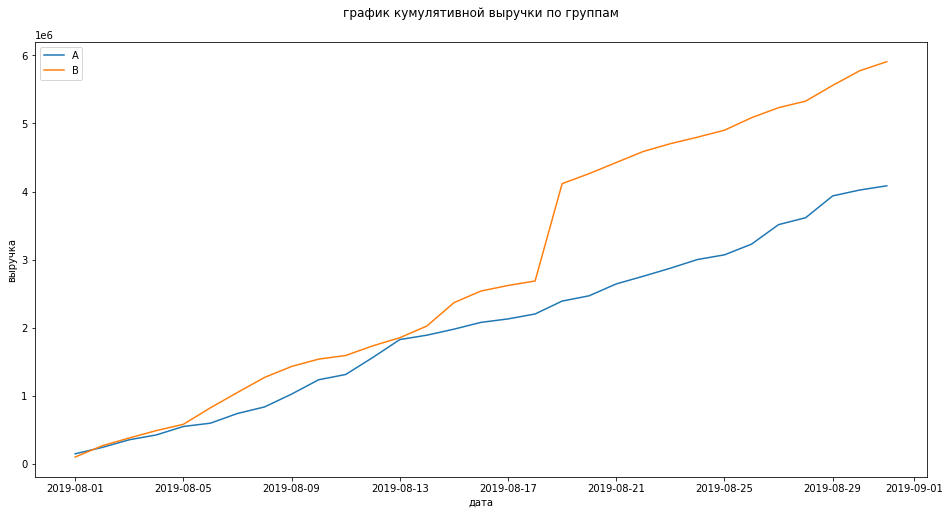

In [15]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


plt.figure(figsize=(16,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A');
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B');
plt.legend();
plt.title('график кумулятивной выручки по группам', pad=25);
plt.xlabel("дата")
plt.ylabel("выручка");

* Судя по графику, кумулятивная выручка группы В стабильно растет. Но есть большой скачок после 17 августа, возможно были какие-то аномально крупные заказы.

### график кумулятивного среднего чека по группам

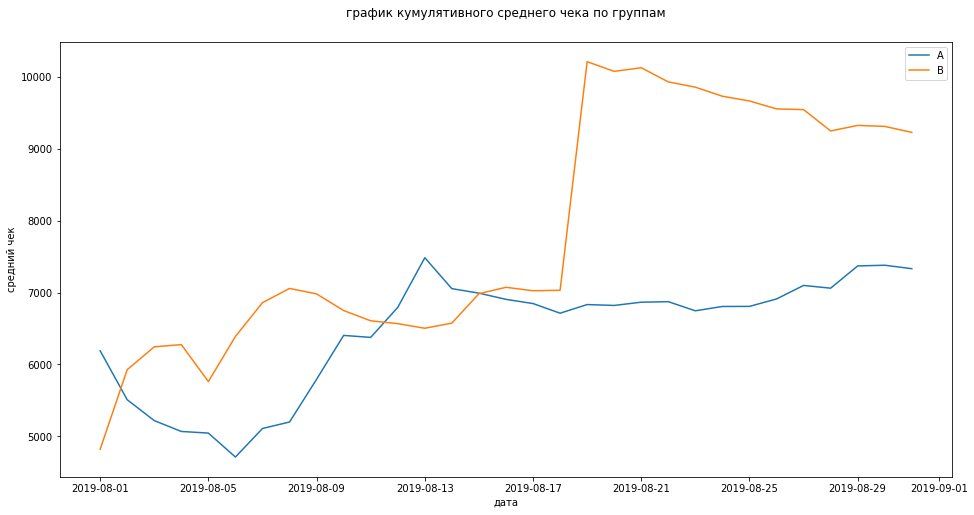

In [16]:
plt.figure(figsize=(16,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xlabel("дата")
plt.ylabel("средний чек");
plt.title('график кумулятивного среднего чека по группам', pad=25);

* средний чек группы В также растет. И также есть резкий скачок среднего чека после 17 августа. В группе А есть небольшой росто после 5 августа, дальше чек почти не меняется.

### график относительного изменения кумулятивного среднего чека группы B к группе A

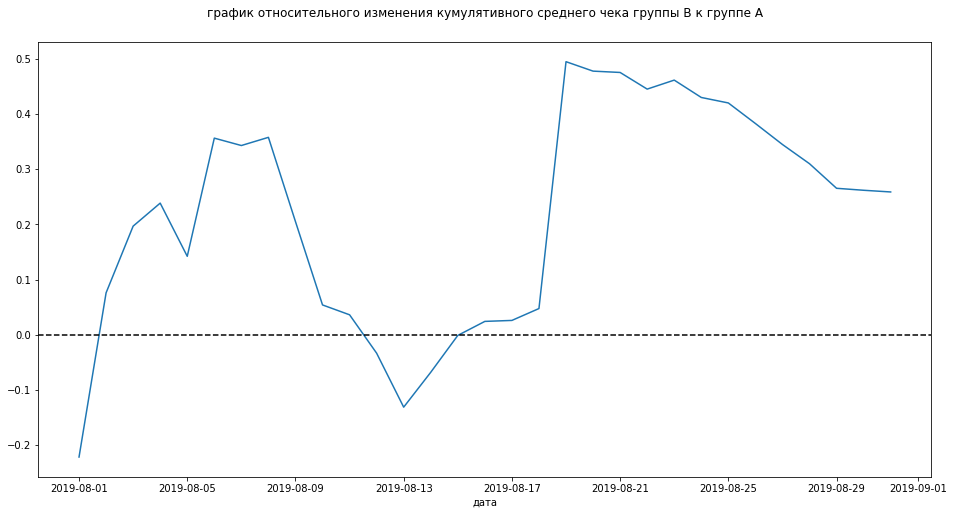

In [17]:
plt.figure(figsize=(16,8))
mergedCumulativeRevenue = cumulativeRevenueA\
.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']
                                                                                   /mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("дата")

plt.title('график относительного изменения кумулятивного среднего чека группы B к группе A', pad=25);

* Данные по группе В в целом растут, но заметен резкий провал примерно 13 августа, а после 17 опять резкий скачок. Возможно в группе А были крупные заказы или очень много покупок

### график кумулятивной конверсии по группам

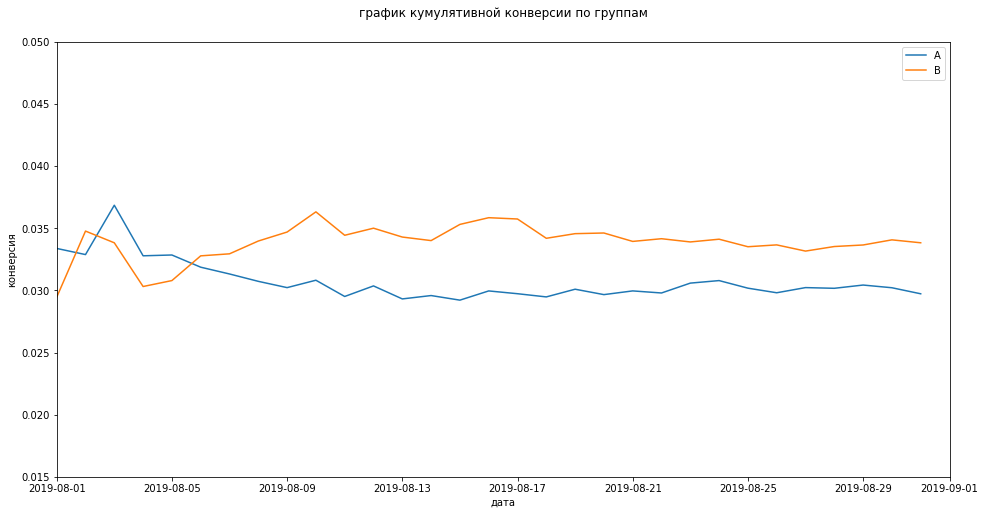

In [18]:
plt.figure(figsize=(16,8))
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel("дата")
plt.ylabel("конверсия");
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.015, 0.05])
plt.title('график кумулятивной конверсии по группам', pad=25);

* В группе В конверсия стабильно растет и становится больше конверсии группы А

### график относительного изменения кумулятивной конверсии группы B к группе A

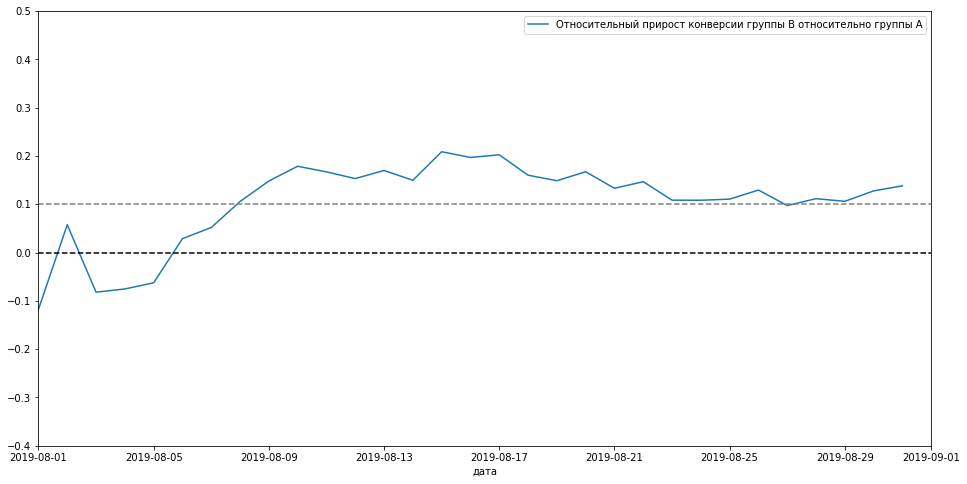

In [19]:
plt.figure(figsize=(16,8))
mergedCumulativeConversions = cumulativeDataA[['date','conversion']] \
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.xlabel("дата")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.4, 0.5]);

* Относительное значение прироста конверсии группы В к группе А также растет, за исключением провала между 1 и 5 августа. Но к концу наблюдений рост стабильный

### точечный график количества заказов по пользователям

In [20]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

In [21]:
ordersByUsers.columns = ['userId', 'orders']

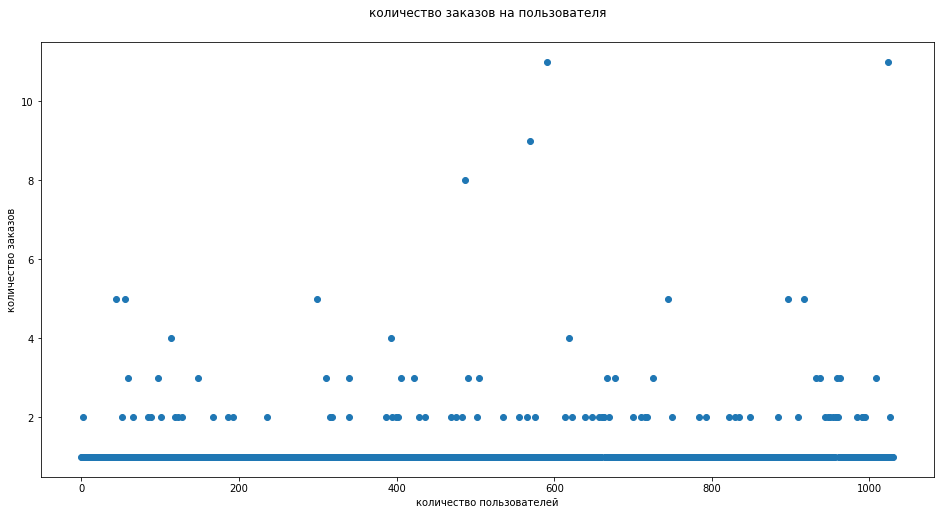

In [22]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(16,8))
plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel("количество пользователей")
plt.ylabel("количество заказов");
plt.title('количество заказов на пользователя', pad=25);

* На графике видим, что в основном пользователи совершают 1-2 заказа. НЕмного пользователей делают 3 и больге заказов. Чтобы узнать границы, по которым можно отсеять аномальные заказы и пользователей, найдем 95 и 99 перцентили

### 95-й и 99-й перцентили количества заказов на пользователя

In [23]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

* Всего лишь 5% совершают больше 2 заказов, и всего 1% больше 4. Для определения аномальных пользователей возьмем за граничное значение 2 заказа - таким образом остается 95% пользователей.

### точечный график стоимостей заказов

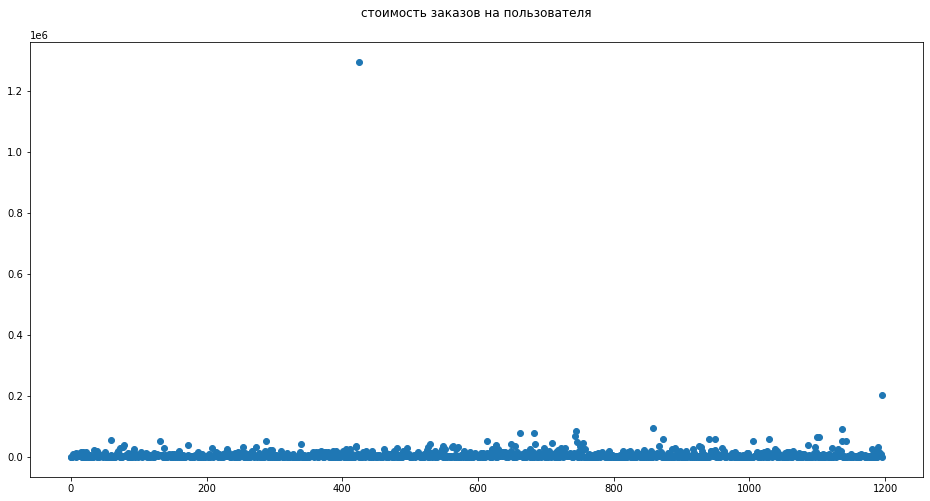

In [24]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(16,8))
plt.scatter(x_values, orders['revenue'])
plt.title('стоимость заказов на пользователя', pad=25);

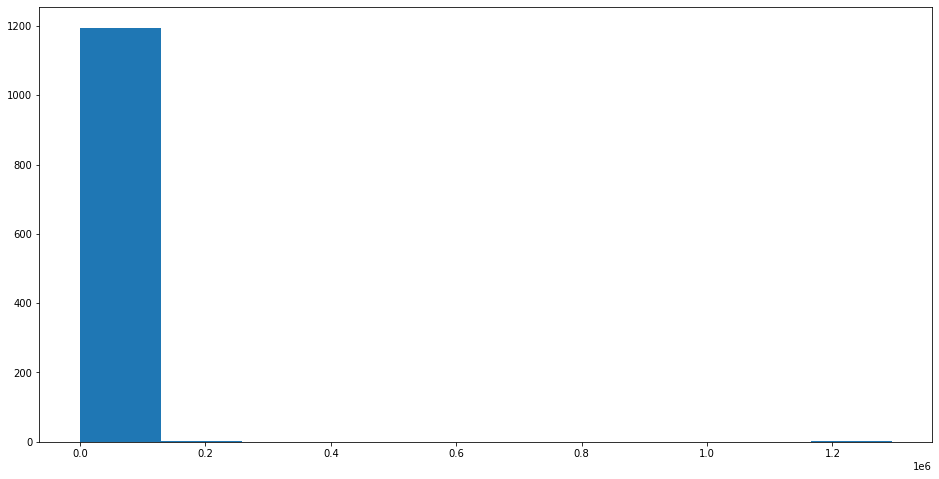

In [25]:
plt.figure(figsize=(16,8))
plt.hist(orders['revenue']);

* по графику рассеяния видим, что есть некий аномальный заказ на 1.2 млн, но основная масса по стоимости сгруппирована около нуля. По гистограмме более детально видим, что почти все заказы по стоимости не превышают 100 тыс. Посмотрим теперь на перцентили

### 95-й и 99-й перцентили стоимости заказов

In [26]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

* 1% пользователей делают заказы на сумму свыше 58 тыс., а 5% свыше 28 тыс. Возьмем за границу для отфильтровки аномалий 28 тыс. и таким образом оставим в выботке оставшихся 95% пользователей

### предварительные таблицы

In [27]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [28]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [29]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [30]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [31]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

### статистическая значимость различий в конверсии между группами по «сырым» данным

Для определения статистической значимости зададимся следующими гипотезами:


**H0 (нулевая гипотеза) - статистически значимых различий в конверсии между группами по сырым данным нет**

**H1 (альтернативная гипотеза) - статистически значимые различия между конверсиями двух групп по сырым данным есть**

Установим уровень статистической значимости равным alpha=0.05

In [32]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']
 
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']
 
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors']\
                     .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors']\
                     .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)
 
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.01679
0.138


* Так как p-value получился меньше 0.05, то мы можем отвергнуть нулевую гипотезу, между группами есть статистические различия в конверсии. Также мы видим, что конверсия в группе В превышает конверсию в группе А примерно на 14%

### статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

**H0 (нулевая гипотеза) - статистически значимых различий в среднем чеке между группами по сырым данным нет**

**H1 (альтернативная гипотеза) - статистически значимые различия в среднем чеке двух групп по сырым данным есть**

Уровень статистической значимости равным alpha=0.05

In [33]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


* p-value значительно превышает 0.05, значит мы не можем отвергнуть нулевую гипотезу, между средними чеками двух групп есть различия. Средний чек группы В на 25% превышает средний чек группы А.

### статистическая значимость различий в конверсии между группами по «очищенным» данным

**H0 (нулевая гипотеза) - статистически значимых различий в конверсии между группами по очищенным данным нет**

**H1 (альтернативная гипотеза) - статистически значимые различия в в конверсии двух групп по очищенным данным есть**

Уровень статистической значимости равным alpha=0.05

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [35]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [36]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [37]:
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01304
0.173


* Так как p-value получился меньше 0.05, то мы можем отвергнуть нулевую гипотезу, между группами есть статистические различия в конверсии. Также мы видим, что конверсия в группе В превышает конверсию в группе А примерно на 17%. Аномальные пользователи немного повлияли на результат.

### статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

**H0 (нулевая гипотеза) - статистически значимых различий в среднем чеке между группами по очищенным данным нет**

**H1 (альтернативная гипотеза) - статистически значимые различия в среднем чеке двух групп по очищенным данным есть**

Уровень статистической значимости равным alpha=0.05

In [38]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.738
-0.020


*  p-value снова получился больше 0.05, по очищенным данным также не получается отвергнуть нулевую гипотезу. Но при этом средний чек группы В почти не отличается от группы А, в группе В чек чуть меньше чека группы А, примерно на 2%.

## Выводы

По определению стат.значимости мы выяснили, что между конверсиями групп А и В имеются статистические различия, и конверсия в группе В выше. Также графики кумулятивной выручки и конверсии подтверждают рост этих параметров к концу исследования. А вот статистической разницы между средним чеком групп А и В не удалось подтвердить ни по сырым, ни по очищенным данным. Относительная разница между средними чеками по чистым данным также незначительна - у группы В средний чек чуть меньше. В целом мы можем принять решение о завершении А/В теста и зафиксировать победу группы В - различие конверсии в группах является статистически значимым
